# SmogCasting

**Author: C. Hull** (github: [chat.hull](http://github.com/chat.hull))

## Introduction 

This is a project analyzing historical data of the air quality in Santiago, Chile 

The data for a representative weather station in central Santiago can be found here: https://sinca.mma.gob.cl/index.php/estacion/index/key/D14

Shout-outs to the many posts/github pages that helped me out!

* Laura Fedoruk: time-series manipulation in pandas, https://towardsdatascience.com/basic-time-series-manipulation-with-pandas-4432afee64ea
* Facebook Prophet quick-start guide: https://facebook.github.io/prophet/docs/quick_start.html#python-api
* Adding addition regressors to Prophet: https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb
* AQI lookup table: http://www.sparetheair.com/publications/AQI_Lookup_Table-PM25.pdf
* AQI calculation: https://metone.com/how-to-calculate-aqi-and-nowcast-indices/
* timeanddate historical weather data: https://www.timeanddate.com/weather/chile/santiago/historic?month=8&year=2020
* How to display altair plot in Flask: https://github.com/xofbd/sql-viz-project/blob/minimal-app/app/app.py

In [ ]:
# TODO
# Add holiday regressor
# Create function to run in the cron script
# Put a good/fair/bad/horrible legend

In [2]:
# Altair workflow: VZ_Explanatory_Visualization.ipynb; can just output the HTML

In [2]:
%%javascript

// Prevent scrolling with large/multiple plots
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from ediblepickle import checkpoint
import time
import datetime as dt
from datetime import date
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as rmse
from IPython.display import display, Markdown, Latex

# Facebook Prophet modeling
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly

# Helper functions
from smogHelpers import calcAQI, formatDates

## Selecting the data

There are many pollutants tracked, including SO<sub>2</sub>, NO, NO<sub>2</sub>, CO, O<sub>3</sub>, NO<sub>X</sub>, non-methanic hydrocarbons, PM10, and PM2.5. However, not all stations in Santiago have continuous time coverage of all of them.  We focus on PM10, PM2.5, and weather data (temperature, relative humidity, wind speed, and wind direction) at the Parque O'Higgins station in central Santiago, starting in late 2003.

In [4]:
# Stations: 
# D14 (Parque O'Higgins; start date: 031216)
# D27 (Puente Alto; start date: 090125)
station = 'D14'
date_from = '031216'
date_to = date.today().strftime("%y%m%d")

# Base URL, defining sensor station
url1 = f'https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=txt&macro=./RM/{station}'
# End url, beginning with date range
url2 = f'&from={date_from}&to={date_to}&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath='
# Sensor-specific URL text
url_sensor = {
    'pm25': '/Cal/PM25//PM25.horario.horario.ic',
    'pm10': '/Cal/PM10//PM10.horario.horario.ic',
    'rhum': '/Met/RHUM//horario_000.ic',
    'temp': '/Met/TEMP//horario_000.ic',
    'wspd': '/Met/WSPD//horario_000.ic',
    'wdir': '/Met/WDIR//horario_000_spec.ic'
}

# Build URL for each observable: 
# Particulate matter (PM2.5 and PM10) and weather data (relative humidity, temperature, wind speed, & wind direction)
sensor_urls = dict([ (key, {'name': key, 'url': url1 + val + url2}) for key,val in url_sensor.items() ])


## Query SINCA website, format data, and produce final pandas dataframe


In [5]:
# This checkpoint will generate one set of data files per day
@checkpoint(key=lambda args, kwargs: '_'.join([args[0], date_from, date_to, station])+'.response.pkl', work_dir='./data/', refresh=False)
def getData(series) :
    time.sleep(1)
    
    # Import PM2.5 or PM10 data
    if series in ['pm25', 'pm10'] :
        df = pd.read_csv(sensor_urls[series]['url'], 
                         names=['date','time','validated','preliminary','non-validated'], 
                         dtype={'date':str, 'time':str}, 
                         usecols=[0,1,2,3,4], 
                         comment='#', 
                         skiprows=36, 
                         skipfooter=9, 
                         encoding='ISO-8859-1', 
                         engine='python')

    # Import weather data    
    else :
        df = pd.read_csv(sensor_urls[series]['url'], 
                         names=['date','time',sensor_urls[series]['name']], 
                         dtype={'date':str, 'time':str}, 
                         usecols=[0,1,2], 
                         comment='#', 
                         skiprows=32, 
                         skipfooter=5, 
                         encoding='ISO-8859-1', 
                         engine='python')
    
    # Format dates
    df = formatDates(df)

    # Replace white space with NaNs
    df = df.replace(r'^\s+$', np.nan, regex=True)
    
    # For PM2.5 or PM10 data, combine validated, preliminary, and non-validated data columns
    if series in ['pm25', 'pm10'] :
        df[sensor_urls[series]['name']] = df['validated'].combine_first(df['preliminary']).combine_first(df['non-validated'])
        df = df.drop(columns=['validated','preliminary','non-validated'])
    
    # Convert unicode to floats
    df[sensor_urls[series]['name']] = pd.to_numeric(df[sensor_urls[series]['name']])

    # Interpolate missing values; assume default method ('linear')
    df[sensor_urls[series]['name']] = df[sensor_urls[series]['name']].interpolate()

    return df

In [6]:
# Empty DataFrame for all data
df_tot = pd.DataFrame(columns=['datetime'])

# Merge all 6 series into full DataFrame
for series in sensor_urls : 
    df = getData(series)
    df_tot = pd.merge(df_tot, df, on='datetime', how='outer')
    df_tot = df_tot.sort_values('datetime')
    df_tot = df_tot.reset_index(drop=True)

In [7]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161447 entries, 0 to 161446
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  161447 non-null  datetime64[ns]
 1   pm25      161447 non-null  float64       
 2   pm10      161447 non-null  float64       
 3   rhum      161447 non-null  float64       
 4   temp      161447 non-null  float64       
 5   wspd      161447 non-null  float64       
 6   wdir      161447 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 8.6 MB


In [8]:
df_tot.tail(15)

,datetime,pm25,pm10,rhum,temp,wspd,wdir
161432,2022-05-16 09:00:00,72.0,165.0,69.4167,11.1167,0.470206,158.136
161433,2022-05-16 10:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161434,2022-05-16 11:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161435,2022-05-16 12:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161436,2022-05-16 13:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161437,2022-05-16 14:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161438,2022-05-16 15:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161439,2022-05-16 16:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161440,2022-05-16 17:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515
161441,2022-05-16 18:00:00,71.0,168.0,57.9167,14.1667,0.634640,139.515


# Run the Prophet time-series prediction

In [9]:
# Today!
today = date.today()

In [10]:
# Strip out ds (datestamp) and pm2.5 (for the y column) for the Prophet prediction
df_prophet = df_tot[['datetime','pm25']]

# Command with extra regressors
# df_prophet = df_tot[['datetime','pm25','wspd','wdir','temp','rhum']]
# df_prophet = df_tot[['datetime','pm25','wspd']]

# Rename columns to comply with Prophet naming requirements
df_prophet = df_prophet.rename(columns={'datetime':'ds', 'pm25':'y'})

# Set end of the training dataset to be today minus 1 week
df_prophet = df_prophet[(df_prophet['ds'] < str(today - dt.timedelta(weeks=1)) )]
# TODO: Set end of the training dataset to be today
# df_prophet = df_prophet[(df_prophet['ds'] < str(today) )]
# TODO TEST: short training set for testing -- uncomment to avoid using all of the data
# df_prophet = df_prophet[(df_prophet['ds'] > str(today - dt.timedelta(days=365*3)) )]

df_prophet

,ds,y
0,2003-12-16 01:00:00,29.0
1,2003-12-16 02:00:00,36.0
2,2003-12-16 03:00:00,35.0
3,2003-12-16 04:00:00,27.0
4,2003-12-16 05:00:00,48.0
...,...,...
161250,2022-05-08 19:00:00,33.0
161251,2022-05-08 20:00:00,35.0
161252,2022-05-08 21:00:00,37.0
161253,2022-05-08 22:00:00,42.0


In [11]:
# Perform a simple prediction of Santiago's AQI using Prophet
# Prophet requires a df (named 'df') with columns named 'ds' (datestamp) and 'y' (numeric measurement to be forecast)
# Instantiate model 
m = Prophet(
    seasonality_mode='additive',
    changepoint_prior_scale=0.01,
)

In [12]:
# TODO: testing changes to the prior scale of the daily seasonality.  Didn't make a difference (0.1 --> 10000).
# To do this, need to set daily_seasonality=False
# m.add_seasonality(
#     name='test',
#     period=1, # 1 day
#     fourier_order=10,
#     prior_scale=0.1,
#     mode='additive'
# )

In [13]:
#m?
#m.add_seasonality?

In [14]:
# Add extra regressors
# m.add_regressor('wspd', prior_scale=0.5, mode='additive')
# m.add_regressor('wdir', prior_scale=0.5, mode='additive')
# m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
# m.add_regressor('rhum', prior_scale=0.5, mode='multiplicative')

In [15]:
# Fit model (takes 2-3 min for full ~20-year dataset)
m.fit(df_prophet)

/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -57.7004


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        546174    0.00365759       47012.5           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        546298    0.00280924       15981.8           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        546392    0.00176001       21846.1      0.4522      0.4522      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        546428   0.000228369       2516.49           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        546447    0.00166946       8039.89           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [16]:
# Look at coefficients of extra regressors
# regressor_coefficients(m)

In [17]:
# Make future df (predict for 1 week)
# future df is the length of the training set + the length of the prediction period
future = m.make_future_dataframe(periods=7*24, freq='H')

# TODO: with extra regressors
# future = df_tot[['datetime','wspd','wdir','temp','rhum']]
# future = df_tot[['datetime','wspd']]

# Rename columns to comply with Prophet naming requirements
future = future.rename(columns={'datetime':'ds'})

# TODO: Have the future dataframe go to the end of the original df_tot; the command below is for the short, 3-year test df
# future = future[(future['ds'] > str(today - dt.timedelta(days=365*3)) )]
future

,ds
0,2003-12-16 01:00:00
1,2003-12-16 02:00:00
2,2003-12-16 03:00:00
3,2003-12-16 04:00:00
4,2003-12-16 05:00:00
...,...
161418,2022-05-15 19:00:00
161419,2022-05-15 20:00:00
161420,2022-05-15 21:00:00
161421,2022-05-15 22:00:00


In [18]:
# Make forecast (takes 1 minute)
forecast = m.predict(future)

/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [19]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2003-12-16 01:00:00,29.366005,6.632247,53.299111
1,2003-12-16 02:00:00,28.132288,4.451008,51.988270
2,2003-12-16 03:00:00,26.526190,3.133284,49.626201
3,2003-12-16 04:00:00,25.845488,0.954906,48.455697
4,2003-12-16 05:00:00,27.111183,2.380414,51.062493
...,...,...,...,...
161418,2022-05-15 19:00:00,29.526523,4.570369,53.130805
161419,2022-05-15 20:00:00,30.878435,8.835881,55.896735
161420,2022-05-15 21:00:00,31.993659,8.446827,55.130076
161421,2022-05-15 22:00:00,33.032559,9.571126,56.723721


# Compare future prediction with test data (i.e., last week's data)

Text(0.78, 0.75, 'RMSE = 20.6 $\\mu$g/m$^3$')

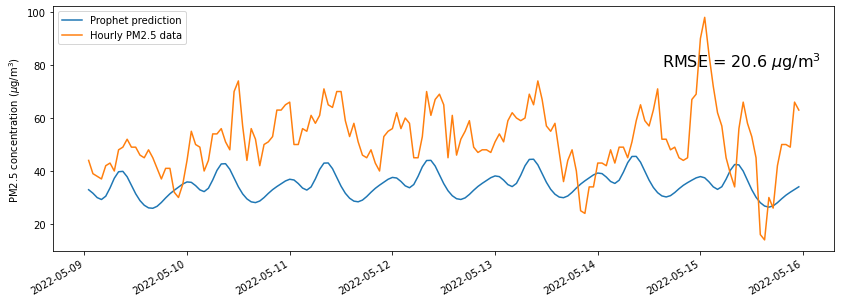

In [20]:
t_min= str(today - dt.timedelta(weeks=1))
t_max= str(today)

# Date range (select from forecast)
dates_model = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] < t_max)]
# Predictions for most recent week
values_model = forecast['yhat'][(forecast['ds'] > t_min) & (forecast['ds'] < t_max)]
# Data from most recent week
values = df_tot['pm25'][(df_tot['datetime'] > t_min) & (df_tot['datetime'] < t_max)]
# TODO: wind speed data
values_wspd = 10*df_tot['wspd'][(df_tot['datetime'] > t_min) & (df_tot['datetime'] < t_max)]

fig, ax = plt.subplots(figsize=(14, 5))
ax.set_ylabel('PM2.5 concentration ($\mu$g/m$^3$)')
#ax.set_ylim(-5,270)
ax.plot(dates_model, values_model, '-', label='Prophet prediction')
ax.plot(dates_model, values, '-', label='Hourly PM2.5 data')
# ax.plot(dates_model, values_wspd.shift(0), 'k-', label='Wind speed')
fig.autofmt_xdate()
ax.legend()

# Calculate RMSE of values vs. model
error = rmse(values, values_model, squared=False)
plt.annotate('RMSE = {0} $\mu$g/m$^3$'.format(round(error,1)), xy=(0.78, 0.75), xycoords='axes fraction', fontsize=16)

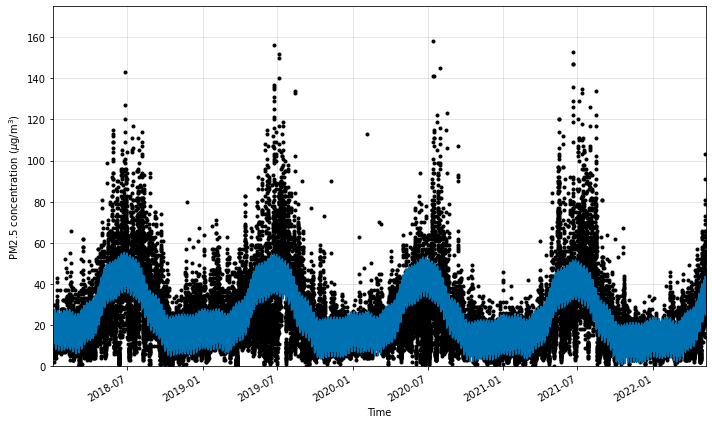

In [67]:
# Manually build model plot with appropriate axes
figsize=(10, 6)
fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)
fcst_t = forecast['ds'].dt.to_pydatetime()
ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
ax.plot(fcst_t, forecast['yhat'], ls='-', c='#0072B2')
#ax.fill_between(fcst_t, forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('PM2.5 concentration ($\mu$g/m$^3$)')
ax.set_xlim([dt.datetime(2018, 1, 1, 1, 0), today - dt.timedelta(weeks=1)])
ax.set_ylim([0,175])
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('model.png', dpi=200)

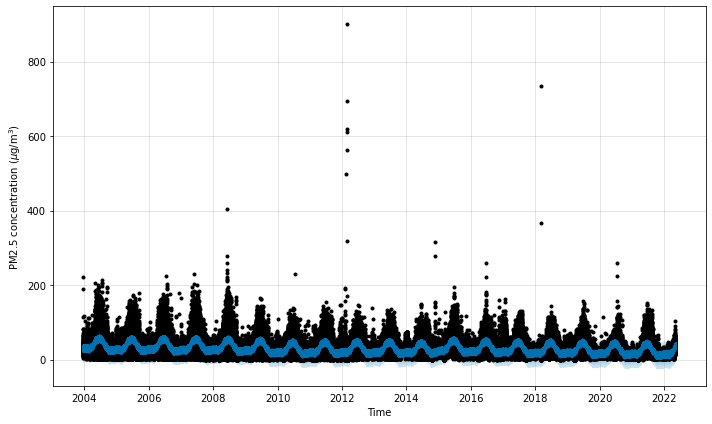

In [36]:
# Full model fit + data (plus tiny 1-week forecast at the end)
fig1 = m.plot(forecast, xlabel='Time', ylabel='PM2.5 concentration ($\mu$g/m$^3$)')

## The model shows the following: 

(1) The PM2.5 concentration is decreasing year over year<br>
(2) The AQI gets worse as the week progresses<br>
(3) The AQI is worse in the winter (Jun-Aug in the southern hemisphere)<br>
(4) the AQI is best around 4 p.m.

/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/chat/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


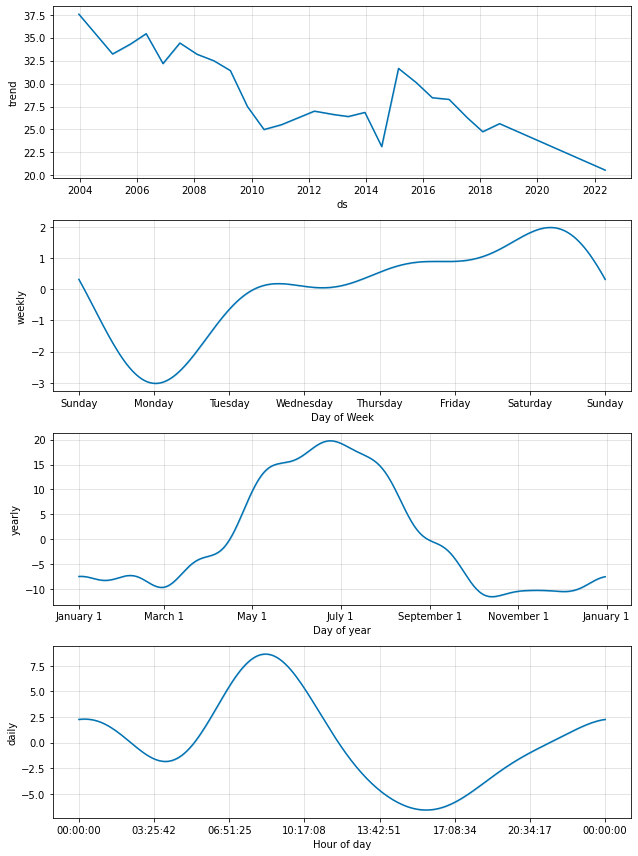

In [22]:
# Static plot of components
fig2 = m.plot_components(forecast)

## Make static forecast plot

In [4]:
now   = dt.datetime.now()
t_min = str(now - dt.timedelta(1))
t_max = str(now + dt.timedelta(2))
# Plot until now minus 2 hr, because data aren't in real-time
t_max_data = str(now - dt.timedelta(hours=2))

# Date range (select from forecast)
dates_model = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] < t_max)]
# Predictions for most recent week
values_model = forecast['yhat'][(forecast['ds'] > t_min) & (forecast['ds'] < t_max)]
# Convert to AQI
values_model = values_model.apply(calcAQI)

# Make the plot
fig, ax = plt.subplots(figsize=(14, 5))
# ax.set_title('Air Quality Index (AQI) forecast for downtown Santiago, Chile', size=22, color='gray')
ax.set_ylabel('AQI', size=20, color='gray')
#ax.set_ylim(-5,270)
ax.tick_params(axis='x', labelsize=20, labelcolor='gray')
ax.tick_params(axis='y', labelsize=20, labelcolor='gray')
ax.set_xlim(min(dates_model),max(dates_model))

# Plot model
ax.plot(dates_model, values_model, '-', linewidth=3, label='Prophet prediction')

# Plot data
dates_data = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] < t_max_data)]
data = df_tot['pm25'][(df_tot['datetime'] > t_min) & (df_tot['datetime'] < t_max_data)]
data = data.apply(calcAQI)
ax.plot(dates_data, data, '-', label='Hourly PM2.5 data')

# Format background
sns.set_style('whitegrid')
sns.despine(fig=fig, ax=ax, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

# Format dates on x-axis
myFmt = mdates.DateFormatter('%b %d, %H:00')
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()

# Print when the plot was updated
now = dt.datetime.now()
updated = now.strftime("Updated %d %b %Y, %H:%M CLT")
plt.annotate(updated, xy=(0.775, 0.03), xycoords='axes fraction', fontsize=12, color='gray')

# Save figure
# plt.tight_layout()
# plt.savefig('AQI.png', dpi=80)

## Comparing the Prophet model with sample data

The Prophet model fits the data much better in the summer. In the winter, other variables (rain, erratic wind) come into play.

In [3]:
for i,dates in enumerate( [['2019-12-1','2020-2-28'],['2020-6-1','2020-8-31']] ) :
    t_min = dates[0]
    t_max = dates[1]
    # From model
    dates_model = forecast['ds'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
    values_model = forecast['yhat'][(forecast['ds'] > t_min) & (forecast['ds'] <= t_max)]
    # Actual data
    values = df_tot['pm25'][(df_tot.index > t_min) & (df_tot.index <= t_max)]

    # Plot comparison
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_ylabel('PM2.5 concentration ($\mu$g/m$^3$)')
    ax.set_ylim(-5,270)
    ax.plot(dates_model,values_model, '-', label='Prophet prediction')
    ax.plot(values, '-', label='Hourly PM2.5 data')
    fig.autofmt_xdate()
    ax.legend()
    
    # Calculate RMSE of values vs. model
    error = rmse(values, values_model, squared=False)
    
    if i==0 :
        plt.annotate('Summer\nRMSE = {0} $\mu$g/m$^3$'.format(round(error)), xy=(0.65, 0.65), xycoords='axes fraction', fontsize=16)
    elif i==1 :
        plt.annotate('Winter\nRMSE = {0} $\mu$g/m$^3$'.format(round(error)), xy=(0.65, 0.65), xycoords='axes fraction', fontsize=16)
        for date in [dt.datetime(2020, 6, 12), dt.datetime(2020, 6, 17), dt.datetime(2020, 6, 23), dt.datetime(2020, 6, 29), dt.datetime(2020, 7, 4), dt.datetime(2020, 7, 21), dt.datetime(2020, 8, 25)] :
            plt.axvline(date, ymin=0.4, ymax=0.75, color='gray')    
            plt.annotate('Rain', xy=(date,150), rotation=90)

# Additional test plots

In [ ]:
# Set datetime column as the index of the dataframe
df_tot = df_tot.set_index('datetime')

### PM2.5 concentration vs. year

In [ ]:
# Sample plot: resampled (monthly) PM2.5 concentration vs. year
##### WE CAN SEE A CLEAR DECREASE AS A FUNCTION OF TIME, 
#####   WITH THE WINTER PEAKS AND SUMMER TROUGHS REGISTERING LOWER VALUES ON AVERAGE.
#####   STRANGELY, THIS IS SOMETHING I HAVE NEVER HEARD ON THE NEWS.  I ASSUME IT'S BECAUSE
#####   EMISSION FROM CARS IS PROGRESSIVELY DECREASING AS OLDER CARS ARE TAKEN OFF THE ROAD.
plt.figure(figsize=(10, 5))

t_min='2000-06-01'
t_max='2030-6-01'
plt.plot(df_tot['pm25'][t_min:t_max].resample('W').mean(),'-', label='PM2.5')
plt.xlabel('Year')
plt.ylabel('PM2.5 concentration ($\mu$g/m$^3$)')
plt.legend()

The average PM2.5 concentration has been decreasing with time; why hasn't this been on the news?

### Test of AirVisual prediction vs. the reading of my PurpleAir sensor over a 48-hour period

In [ ]:
airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start='2022-01-13 09:00:00', end='2022-01-15 06:00:00', periods=16)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction')
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('AQI (PM2.5)')
ax.legend()
plt.show()

### AirVisual prediction, PurpleAir sensor, and the Prophet model

In [ ]:
# Test of AirVisual prediction vs. the actual reading of my sensor over a 48-hour period
t_min = '2022-01-13 09:00:00'
t_max = '2022-01-15 06:00:00'
airVisual = [25,25,25,25,25,25,75,75,125,125,75,75,25,25,25,25]
sensor = [85.3, 84.7, 55.3, 42, 27, 28.7, 24.7, 29, 57, 71, 59.3, 28, 17.3, 18.3, 32.7, 36.7]
dates = pd.date_range(start=t_min, end=t_max, periods=16)

# Add the model fit to the plot now
values_model = forecast[['ds','yhat']][(forecast['ds'] >= t_min) & (forecast['ds'] <= t_max)]
values_model = values_model.set_index('ds')
values_model = values_model.resample('3h').mean()
# Convert model values (concentration) to PM2.5 AQI
values_model = [calcAQI(concentration) for concentration in values_model['yhat']]

# Calculate rmse
rmse_airVisual = round(rmse(sensor,airVisual, squared=False))
rmse_model = round(rmse(sensor,values_model, squared=False))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dates,sensor, '.-', label='My PurpleAir sensor')
ax.errorbar(dates,airVisual,25,label='AirVisual prediction (rmse = {0})'.format(rmse_airVisual))
ax.plot(dates,values_model, 'k.-', label='Prophet prediction (rmse = {0})'.format(rmse_model))
fig.autofmt_xdate()
ax.set_title('Comparison of AirVisual app prediction and actual PurpleAir sensor values')
ax.set_xlabel('Datetime (3 hour chunks over 48 hours)')
ax.set_ylabel('AQI (PM2.5)')
ax.legend()
plt.show()

display(Markdown('**The Prophet model fits the PurpleAir data much better than the AirVisual prediction.**'))

## Shifting data to test for lags in variables

In [ ]:
# TODO: Correlation of PM2.5 and wspd is highest -7 hour shift of wind speed (i.e., wind is highest 7 hours after air quality is the worst)
for i in range(-10,0) :
    print(values.corr(values_wspd.shift(i)))